In [2]:
import PyPlot
using NearestNeighbors
using SplineUtils

In [3]:
R(θ) = [cos(θ) -sin(θ); sin(θ) cos(θ)]

R (generic function with 1 method)

# Build Road Networks from Intersections

In [4]:
type Intersection
    id
    x
    y
    θ₁
    θ₂
    connection_N
    connection_E
    connection_S
    connection_W
    function Intersection(id,x,y,θ₁,θ₂)
        retval = new()
        retval.id = id
        retval.x = x
        retval.y = y
        retval.θ₁ = θ₁
        retval.θ₂ = θ₂
        retval.connection_N = -1
        retval.connection_E = -1
        retval.connection_S = -1
        retval.connection_W = -1
        return retval
    end
end

In [5]:
type id_assigner
    available_ids
    function id_assigner(num_ids)
        retval = new()
        retval.available_ids = Set(i for i in 1:num_ids)
        return retval
    end
end

In [6]:
function getId(assigner::id_assigner)
    return pop!(assigner.available_ids)
end

getId (generic function with 1 method)

In [7]:
assigner = id_assigner(100)

id_assigner(Set([68, 2, 89, 11, 39, 46, 85, 25, 55, 42  …  72, 28, 5, 23, 63, 27, 56, 97, 41, 15]))

In [8]:
intersections = Dict()
block_array = Dict()
for i in 0:5
    for j in 0:5
        id = getId(assigner)
        block_array[(i,j)] = id
        θ₁ = rand() / 4
        θ₂ = θ₁ + π/2
        x = i*10.0 + rand()
        y = j*10.0 + rand()
        intersections[id] = Intersection(id, x, y, θ₁, θ₂)
    end
end
for i in 1:4
    for j in 1:4
        id = block_array[(i,j)]
        intersections[id].connection_N = block_array[(i,j+1)]
        intersections[id].connection_E = block_array[(i+1,j)]
        intersections[id].connection_S = block_array[(i,j-1)]
        intersections[id].connection_W = block_array[(i-1,j)]
    end
end

In [9]:
function generateSpline(pt₁, pt₂, θ₁, θ₂; degree=3)
    """
    generates a spline that leaves pt1 at heading θ₁, and arrives
    at pt2 with heading θ₂
    """
    d = norm(pt₁-pt₂)
    V₁ = (d/4) * R(θ₁) * [
        0.0 1.0;
        0.0 0.0
    ] .+ pt₁
    V₂ = (d/4) * R(θ₂) * [
        1.0 0.0;
        0.0 0.0
    ] .+ pt₂
    Pts = hcat(V₁,(V₁[:,end]+V₂[:,1])/2,V₂)
    L_tt = 100
    T, tt, x, y = B_Spline(Pts, degree, L_tt)
    return T, tt, x, y
end

generateSpline (generic function with 1 method)

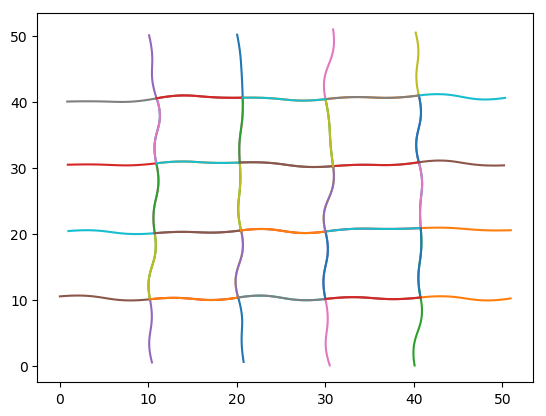

In [10]:
for (id,I) in intersections
    if I.connection_N > -1
        I₂ = intersections[I.connection_N]
        T, tt, x, y = generateSpline([I.x, I.y], [I₂.x, I₂.y], I.θ₂, I₂.θ₂+π)
        PyPlot.plot(x,y) # plot generated spline roadway
    end
    if I.connection_E > -1
        I₂ = intersections[I.connection_E]
        T, tt, x, y = generateSpline([I.x, I.y], [I₂.x, I₂.y], I.θ₁, I₂.θ₁+π)
        PyPlot.plot(x,y) # plot generated spline roadway
    end
    if I.connection_S > -1
        I₂ = intersections[I.connection_S]
        T, tt, x, y = generateSpline([I.x, I.y], [I₂.x, I₂.y], I.θ₂+π, I₂.θ₂)
        PyPlot.plot(x,y) # plot generated spline roadway
    end
    if I.connection_W > -1
        I₂ = intersections[I.connection_W]
        T, tt, x, y = generateSpline([I.x, I.y], [I₂.x, I₂.y], I.θ₁+π, I₂.θ₁)
        PyPlot.plot(x,y) # plot generated spline roadway
    end
end

# Construct Intersection from list of incoming lanes and transitions

In [11]:
# transitions by incoming lanes - lanes listed left to right
NorthLanesIn = [Set([:Left]), Set([:Left]), Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])]
EastLanesIn = [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])]
SouthLanesIn = [Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])]
WestLanesIn = [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])];

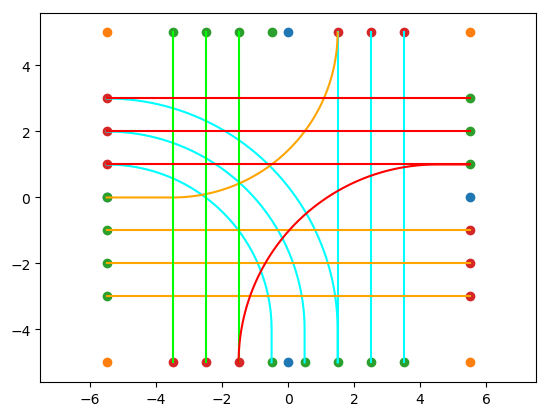

(-6.131589525120512, 6.131589525120512, -5.599999481417249, 5.599999481417249)

In [13]:
# transitions by outgoing lanes - lanes listed left to right
NorthLanesOut = [Set([:Straight]) for i in 1:max(
                        length([lane for lane in NorthLanesIn if :Straight in lane]),
                        length([lane for lane in EastLanesIn if :Left in lane]),
                        length([lane for lane in WestLanesIn if :Right in lane]),
                        )]
EastLanesOut = [Set([:Straight]) for i in 1:max(
                        length([lane for lane in EastLanesIn if :Straight in lane]),
                        length([lane for lane in SouthLanesIn if :Left in lane]),
                        length([lane for lane in NorthLanesIn if :Right in lane]),
                        )]
SouthLanesOut = [Set([:Straight]) for i in 1:max(
                        length([lane for lane in SouthLanesIn if :Straight in lane]),
                        length([lane for lane in WestLanesIn if :Left in lane]),
                        length([lane for lane in EastLanesIn if :Right in lane]),
                        )]
WestLanesOut = [Set([:Straight]) for i in 1:max(
                        length([lane for lane in WestLanesIn if :Straight in lane]),
                        length([lane for lane in NorthLanesIn if :Left in lane]),
                        length([lane for lane in SouthLanesIn if :Right in lane]),
                        )]
D_NS = max(length(NorthLanesIn) + length(SouthLanesOut), length(SouthLanesIn) + length(NorthLanesOut))
D_EW = max(length(EastLanesIn) + length(WestLanesOut), length(WestLanesIn) + length(EastLanesOut));
# incoming lanes - lateral position begins from the right side
NorthLanePositions_In = [i for i in 1:length(NorthLanesIn)]
EastLanePositions_In = [i for i in 1:length(EastLanesIn)]
SouthLanePositions_In = [i for i in 1:length(WestLanesIn)]
WestLanePositions_In = [i for i in 1:length(SouthLanesIn)]
# outgoing lanes - lateral position counts down from left side
NorthLanePositions_Out = [D_NS + 1 - i for i in 1:length(NorthLanesOut)]
EastLanePositions_Out = [D_EW + 1 - i for i in 1:length(EastLanesOut)]
SouthLanePositions_Out = [D_NS + 1 - i for i in 1:length(SouthLanesOut)]
WestLanePositions_Out = [D_EW + 1 - i for i in 1:length(WestLanesOut)]
# leftover positions are empty--no lanes in them
w = 1
b = 1.5 # buffer distance to make intersection less tight
ctr = [0;0]
θ₁ = 0 # theta E-W
θ₂ = θ₁ + π/2 # theta N-S
x₁ = 0
y₁ = 0
dN = w*D_NS/2 + b # width of North-bound road section
dS = w*D_NS/2 + b # width of South-bound road section
dE = w*D_EW/2 + b # width of East-bound road section
dW = w*D_EW/2 + b # width of West-bound road section
south_ctr = [x₁;y₁] - dW * R(θ₂) * [1; 0]
north_ctr = [x₁;y₁] + dE * R(θ₂) * [1; 0]
east_ctr = [x₁;y₁] + dS * R(θ₁) * [1; 0]
west_ctr = [x₁;y₁] - dN * R(θ₁) * [1; 0]
SE_corner = south_ctr + east_ctr
NE_corner = east_ctr + north_ctr
NW_corner = north_ctr + west_ctr
SW_corner = west_ctr + south_ctr

# entry points
NorthEntryPoints = [(SE_corner .+ normalize(west_ctr)*(w*(p-.5) + b)) for p in NorthLanePositions_In]
EastEntryPoints = [(SW_corner .+ normalize(north_ctr)*(w*(p-.5) + b)) for p in EastLanePositions_In]
SouthEntryPoints = [(NW_corner .+ normalize(east_ctr)*(w*(p-.5) + b)) for p in SouthLanePositions_In]
WestEntryPoints = [(NE_corner .+ normalize(south_ctr)*(w*(p-.5) + b)) for p in WestLanePositions_In]
entrances = vcat(NorthEntryPoints, EastEntryPoints, WestEntryPoints, SouthEntryPoints);
# exit points
NorthExitPoints = [(NW_corner .+ normalize(east_ctr)*(w*(p-.5) + b)) for p in NorthLanePositions_Out]
EastExitPoints = [(NE_corner .+ normalize(south_ctr)*(w*(p-.5) + b)) for p in EastLanePositions_Out]
SouthExitPoints = [(SE_corner .+ normalize(west_ctr)*(w*(p-.5) + b)) for p in SouthLanePositions_Out]
WestExitPoints = [(SW_corner .+ normalize(north_ctr)*(w*(p-.5) + b)) for p in WestLanePositions_Out]
exits = vcat(NorthExitPoints, EastExitPoints, WestExitPoints, SouthExitPoints);

PyPlot.scatter(
    [north_ctr[1] east_ctr[1] south_ctr[1] west_ctr[1]],
    [north_ctr[2] east_ctr[2] south_ctr[2] west_ctr[2]])
PyPlot.scatter(
    [SE_corner[1] NE_corner[1] NW_corner[1] SW_corner[1]],
    [SE_corner[2] NE_corner[2] NW_corner[2] SW_corner[2]])
PyPlot.scatter(
    [entrance[1] for entrance in entrances],
    [entrance[2] for entrance in entrances])
PyPlot.scatter(
    [exit[1] for exit in exits],
    [exit[2] for exit in exits])

LanesIn = [NorthLanesIn, EastLanesIn, SouthLanesIn, WestLanesIn]
CenterEntryPoints = [NorthEntryPoints, EastEntryPoints, SouthEntryPoints, WestEntryPoints]
CenterExitPoints = [NorthExitPoints, EastExitPoints, SouthExitPoints, WestExitPoints]
LeftExitPoints = [WestExitPoints, NorthExitPoints, EastExitPoints, SouthExitPoints]
RightExitPoints = [EastExitPoints, SouthExitPoints, WestExitPoints, NorthExitPoints]
LeftCrnrs = [SW_corner, NW_corner, NE_corner, SE_corner]
RightCrnrs = [SE_corner, SW_corner, NW_corner, NE_corner]
colors = ["cyan", "orange", "lime", "red"]

for j in 1:4
    for (i,lane) in enumerate(reverse(LanesIn[j]))
        if :Straight in lane
            pt₁ = CenterEntryPoints[j][i]
            pt₂ = CenterExitPoints[j][i]
            x = collect(linspace(pt₁[1],pt₂[1]))
            y = collect(linspace(pt₁[2],pt₂[2]))
            PyPlot.plot(x,y,c=colors[j])
        end
        if :Right in lane
            x = []
            y = []
            # plot arc 
            pt₁ = CenterEntryPoints[j][i]
            pt₂ = RightExitPoints[j][i]
            ctr = RightCrnrs[j]
            Δ₁ = pt₁ - ctr
            Δ₂ = pt₂ - ctr
            if norm(Δ₂) - norm(Δ₁) > 0.01
                append!(x,pt₁[1])
                append!(y,pt₁[2])
                pt₁ = pt₁ .+ Δ₂*(norm(Δ₂)-norm(Δ₁))/norm(Δ₂)
                ctr = ctr .+ Δ₂*(norm(Δ₂)-norm(Δ₁))/norm(Δ₂)
                Δ₁ = pt₁ - ctr
                r = norm(Δ₁) #* sin(θ₂-θ₁)
                ϕ₁ = atan2(Δ₁[2],Δ₁[1])
                ϕ₂ = atan2(Δ₂[2],Δ₂[1])
                ϕ = collect(linspace(ϕ₁,ϕ₁+mod(ϕ₂-ϕ₁,2*π)))
                x = vcat(x, r*cos.(ϕ) + ctr[1])
                y = vcat(y, r*sin.(ϕ) + ctr[2])
            elseif norm(Δ₁) - norm(Δ₂) > 0.01
                append!(x,pt₂[1])
                append!(y,pt₂[2])
                pt₂ = pt₂ .+ Δ₁*(norm(Δ₁)-norm(Δ₂))/norm(Δ₁)
                ctr = ctr .+ Δ₁*(norm(Δ₁)-norm(Δ₂))/norm(Δ₁)
                Δ₂ = pt₂ - ctr
                r = norm(Δ₁) #* sin(θ₂-θ₁)
                ϕ₁ = atan2(Δ₁[2],Δ₁[1])
                ϕ₂ = atan2(Δ₂[2],Δ₂[1])
                ϕ = collect(linspace(ϕ₁,ϕ₁+mod(ϕ₂-ϕ₁,2*π)))
                x = vcat(r*cos.(ϕ) + ctr[1], x)
                y = vcat(r*sin.(ϕ) + ctr[2], y)
            end
            PyPlot.plot(x,y,c=colors[j])
        end
    end
    for (i,lane) in enumerate(LanesIn[j])
        if :Left in lane
            x = []
            y = []
            pt₁ = reverse(CenterEntryPoints[j])[i]
            pt₂ = reverse(LeftExitPoints[j])[i]
            ctr = LeftCrnrs[j]
            Δ₁ = pt₁ - ctr
            Δ₂ = pt₂ - ctr
            if norm(Δ₂) - norm(Δ₁) > 0.01
                append!(x,pt₁[1])
                append!(y,pt₁[2])
                pt₁ = pt₁ .+ Δ₂*(norm(Δ₂)-norm(Δ₁))/norm(Δ₂)
                ctr = ctr .+ Δ₂*(norm(Δ₂)-norm(Δ₁))/norm(Δ₂)
                Δ₁ = pt₁ - ctr
                r = norm(Δ₁) #* sin(θ₂-θ₁)
                ϕ₁ = atan2(Δ₁[2],Δ₁[1])
                ϕ₂ = atan2(Δ₂[2],Δ₂[1])
                ϕ = collect(linspace(ϕ₁,ϕ₁+mod(ϕ₂-ϕ₁,2*π)))
                x = vcat(x, r*cos.(ϕ) + ctr[1])
                y = vcat(y, r*sin.(ϕ) + ctr[2])
            elseif norm(Δ₁) - norm(Δ₂) > 0.01
                append!(x,pt₂[1])
                append!(y,pt₂[2])
                pt₂ = pt₂ .+ Δ₁*(norm(Δ₁)-norm(Δ₂))/norm(Δ₁)
                ctr = ctr .+ Δ₁*(norm(Δ₁)-norm(Δ₂))/norm(Δ₁)
                Δ₂ = pt₂ - ctr
                r = norm(Δ₁) #* sin(θ₂-θ₁)
                ϕ₁ = atan2(Δ₁[2],Δ₁[1])
                ϕ₂ = atan2(Δ₂[2],Δ₂[1])
                ϕ = collect(linspace(ϕ₁,ϕ₁+mod(ϕ₂-ϕ₁,2*π)))
                x = vcat(r*cos.(ϕ) + ctr[1], x)
                y = vcat(r*sin.(ϕ) + ctr[2], y)
            end
            PyPlot.plot(x,y,c=colors[j])
        end
    end
end
PyPlot.axis("equal")

# Generate Connecting Roadway Geometry (between intersections)

# Dubbins stuff

In [ ]:
function Dubbins(x1,y1,θ1,x2,y2,θ2)
    """
    returns points along Dubbins curve from Pt1 to Pt2
    """
    dx = x2 - x1
    dy = y2 - y1
    dth = th2 - th1
    θₕ = atan2(dy,dx)
    
end

In [ ]:
R = 3
x₁ = 0
y₁ = 0
θ₁ = -π/4

x₂ = 5
y₂ = 2
θ₂ = π/3

Δx = x₂ - x₁
Δy = y₂ - y₁
θₕ = atan2(Δy,Δx)
Δθ₁ = θₕ - θ₁
Δθ₂ = θ₂ - θₕ

c₁₊ = [x₁ - R*sin(θ₁), y₁ + R*cos(θ₁)]
c₁₋ = [x₁ + R*sin(θ₁), y₁ - R*cos(θ₁)]
c₂₊ = [x₂ - R*sin(θ₂), y₂ + R*cos(θ₂)]
c₂₋ = [x₂ + R*sin(θ₂), y₂ - R*cos(θ₂)]

D₊₊ = sqrt(sum((c₁₊ .- c₂₊).^2))
D₊₋ = sqrt(sum((c₁₊ .- c₂₋).^2))
D₋₊ = sqrt(sum((c₁₋ .- c₂₊).^2))
D₋₋ = sqrt(sum((c₁₋ .- c₂₋).^2))

if D₊₊ < 4*R
    # options = straight and circle
else
    # option = straight only
end

if D₊₊ < 4*R
    # options = straight and circle
else
    # option = straight only
end



if indmin(D) == 1
    # CCW, S, CCW
elseif indmin(D) == 2
    # CSC
elseif indmin(D) == 3
elseif indmin(D) == 4
    # CW, S, CW
end
# # Dubbins
# if sqrt((x₂-x₁)^2+(y₂-y₁)^2) > 2*R
#     # curve has a straight segment
#     if Δθ₁ > 0
#         xc₁ = x₁ - R*sin(θ₁)
#         yc₁ = y₁ + R*cos(θ₁)
#         if Δθ₂ > 0
#             xc₂ = x₂ - R*sin(θ₂)
#             yc₂ = y₂ + R*cos(θ₂)
#         else
#             xc₂ = x₂ + R*sin(θ₂)
#             yc₂ = y₂ -R*cos(θ₂)
#         end
#     else
#         xc₁ = x₁ + R*sin(θ₁)
#         yc₁ = y₁ - R*cos(θ₁)
#         if Δθ₂ > 0
#             xc₂ = x₂ - R*sin(θ₂)
#             yc₂ = y₂ + R*cos(θ₂)
#         else
#             xc₂ = x₂ + R*sin(θ₂)
#             yc₂ = y₂ -R*cos(θ₂)
#         end
#     end
# end

# v₁ = [xc₂ - xc₁, yc₂ - yc₁]
# D₁ = sqrt(sum(v₁.*v₁))
# D₂ = -R*sign(Δθ₁)+R*sign(Δθ₂)
# D₃ = sqrt(D₁^2 - D₂^2)
# θᵣ = acos(D₂/D₁) + atan2(v₁[2], v₁[1])
# xp₁= xc₁+R*cos(θᵣ)
# yp₁= yc₁+R*sin(θᵣ)
# xp₂= xc₂-R*cos(θᵣ)
# yp₂= yc₂-R*sin(θᵣ)

PyPlot.scatter(x₁,y₁,c="b")
PyPlot.scatter(x₂,y₂,c="r")
PyPlot.scatter(c₁₊[1],c₁₊[2],c="orange")
PyPlot.scatter(c₂₊[1],c₂₊[2],c="orange")
PyPlot.scatter(c₁₋[1],c₁₋[2],c="cyan")
PyPlot.scatter(c₂₋[1],c₂₋[2],c="cyan")
# PyPlot.scatter(xp₁,yp₁,c="cyan")
# PyPlot.scatter(xp₂,yp₂,c="cyan")

# PyPlot.scatter(x₁+R*[-sin(θ₁), sin(θ₁)], y₁+R*[cos(θ₁), -cos(θ₁)],c="orange")
# PyPlot.scatter(x₂+R*[-sin(θ₂), sin(θ₂)], y₂+R*[cos(θ₂), -cos(θ₂)],c="orange")

PyPlot.plot(x₁+[0,cos(θ₁)],y₁+[0,sin(θ₁)],c="b")
PyPlot.plot(x₂+[0,cos(θ₂)],y₂+[0,sin(θ₂)],c="r")
PyPlot.plot([x₁,x₂],[y₁,y₂],"g")
PyPlot.axis("equal")
